## LABORATORIO 6 
Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

In [1]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

import json, pandas as pd

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pytz

import ast, math
from collections import Counter


import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
txt = open('traficogt.txt','rb').read().decode('utf-16', errors='ignore')

objs, i, n, depth, start, in_str, esc = [], 0, len(txt), 0, None, False, False
while i < n:
    c = txt[i]
    if in_str:
        if esc: esc = False
        elif c == '\\': esc = True
        elif c == '"': in_str = False
    else:
        if c == '"': in_str = True
        elif c == '{':
            if depth == 0: start = i
            depth += 1
        elif c == '}':
            if depth: depth -= 1
            if depth == 0 and start is not None:
                objs.append(txt[start:i+1]); start = None
    i += 1

jh = lambda hs: ', '.join([h if isinstance(h,str) else (h.get('text') or h.get('tag') or h.get('name','')) for h in (hs or []) if h])
jm = lambda ms: ', '.join([m if isinstance(m,str) else (m.get('username') or m.get('displayname','')) for m in (ms or []) if m])

rows = []
for s in objs:
    try:
        o = json.loads(s)
        u = o.get('user') or {}

        reply_to = None
        if o.get("inReplyToUser"):
            reply_to = o["inReplyToUser"].get("username")

        retweeted_user = None
        if o.get("retweetedTweet") and o["retweetedTweet"].get("user"):
            retweeted_user = o["retweetedTweet"]["user"].get("username")

        rows.append({
            'username': u.get('username'),
            'date': o.get('date'),
            'rawContent': o.get('rawContent'),
            'replyCount': o.get('replyCount'),
            'retweetCount': o.get('retweetCount'),
            'likeCount': o.get('likeCount'),
            'hashtags': jh(o.get('hashtags')),
            'mentionUsers': jm(o.get('mentionedUsers')),
            'viewCount': o.get('viewCount'),
            "reply_to": reply_to,
            "retweeted_user": retweeted_user
        })
    except Exception:
        pass  

cols = ["username","date","rawContent", "replyCount","retweetCount","likeCount","hashtags","mentionUsers","viewCount","reply_to","retweeted_user"]
df = pd.DataFrame(rows)[cols]

Se seleccionaron las variables del archivo txt para usar en el laboratorios. Se colocaron en el dataframe las siguientes variables:
- Username 
- Date
- RawContent
- ReplyCount
- RetweetCount
- LikeCount 
- Hashtags
- MentionUsers
- ViewCount
- Reply_to
- Retweeted_User 

In [3]:
df

username                       date  \
0           traficogt  2024-09-12 14:22:06+00:00   
1        monymmorales  2024-09-12 00:39:56+00:00   
2     animaldgalaccia  2024-09-12 01:21:04+00:00   
3      EstacionDobleA  2024-09-11 20:20:01+00:00   
4          CubReserva  2024-09-11 00:34:31+00:00   
...               ...                        ...   
5599   guiselabarrios  2023-10-08 21:58:09+00:00   
5600        mvtrooper  2023-10-08 21:37:45+00:00   
5601      elmeronene1  2023-10-08 21:37:19+00:00   
5602        mvtrooper  2023-10-08 21:31:24+00:00   
5603  91072dff5a5a4f1  2023-10-08 21:13:33+00:00   

                                             rawContent  replyCount  \
0     Es comprensible la resolución... El ruso sabe ...           0   
1     La corrupción de la @CC_Guatemala\nes descarad...           0   
2     @PNCdeGuatemala @mingobguate @FJimenezmingob @...           0   
3     @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...           0   
4     @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...           0   
...                                                 ...         ...   
5599  @traficogt Y no que presentando 5 mil firmas a...           0   
5600  @hshetemul @traficogt Y de igual Manera quitan...           0   
5601  @traficogt Es algo más fuerte que ellos no qui...           0   
5602  @Factor4_GT @traficogt @CC_Guatemala @MPguatem...           0   
5603           @AgenciaOcote @traficogt Vieja ignorante           0   

      retweetCount  likeCount hashtags  \
0                0          1            
1               56         84            
2                0          1            
3                0          0            
4                0          1            
...            ...        ...      ...   
5599             0          0            
5600             0          0            
5601             0          0            
5602             0          0            
5603             0          0            

                                           mentionUsers  viewCount  \
0                                                            393.0   
1                                          CC_Guatemala     1587.0   
2     PNCdeGuatemala, mingobguate, FJimenezmingob, d...       91.0   
3     amilcarmontejo, AztecaNoticiaGT, BancadaSemill...       46.0   
4     soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...      171.0   
...                                                 ...        ...   
5599                                          traficogt        8.0   
5600   hshetemul, traficogt, MPguatemala, CangGuatemala        3.0   
5601                                          traficogt       21.0   
5602   Factor4_GT, traficogt, CC_Guatemala, MPguatemala        4.0   
5603                            AgenciaOcote, traficogt       17.0   

            reply_to retweeted_user  
0               None           None  
1               None           None  
2     PNCdeGuatemala           None  
3     EstacionDobleA           None  
4         CubReserva           None  
...              ...            ...  
5599       traficogt           None  
5600       hshetemul           None  
5601       traficogt           None  
5602      Factor4_GT           None  
5603    AgenciaOcote           None  

[5604 rows x 11 columns]

In [4]:
df.info()
display(df.head())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   username        5604 non-null   object 
 1   date            5604 non-null   object 
 2   rawContent      5604 non-null   object 
 3   replyCount      5604 non-null   int64  
 4   retweetCount    5604 non-null   int64  
 5   likeCount       5604 non-null   int64  
 6   hashtags        5604 non-null   object 
 7   mentionUsers    5604 non-null   object 
 8   viewCount       5600 non-null   float64
 9   reply_to        4150 non-null   object 
 10  retweeted_user  0 non-null      object 
dtypes: float64(1), int64(3), object(7)
memory usage: 481.7+ KB


username                       date  \
0        traficogt  2024-09-12 14:22:06+00:00   
1     monymmorales  2024-09-12 00:39:56+00:00   
2  animaldgalaccia  2024-09-12 01:21:04+00:00   
3   EstacionDobleA  2024-09-11 20:20:01+00:00   
4       CubReserva  2024-09-11 00:34:31+00:00   

                                          rawContent  replyCount  \
0  Es comprensible la resolución... El ruso sabe ...           0   
1  La corrupción de la @CC_Guatemala\nes descarad...           0   
2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...           0   
3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...           0   
4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...           0   

   retweetCount  likeCount hashtags  \
0             0          1            
1            56         84            
2             0          1            
3             0          0            
4             0          1            

                                        mentionUsers  viewCount  \
0                                                         393.0   
1                                       CC_Guatemala     1587.0   
2  PNCdeGuatemala, mingobguate, FJimenezmingob, d...       91.0   
3  amilcarmontejo, AztecaNoticiaGT, BancadaSemill...       46.0   
4  soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...      171.0   

         reply_to retweeted_user  
0            None           None  
1            None           None  
2  PNCdeGuatemala           None  
3  EstacionDobleA           None  
4      CubReserva           None

username             0
date                 0
rawContent           0
replyCount           0
retweetCount         0
likeCount            0
hashtags             0
mentionUsers         0
viewCount            4
reply_to          1454
retweeted_user    5604
dtype: int64

In [5]:

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish')).union({'ma', 'si'})
 
URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')  
HASHTAG_RE = re.compile(r'#(\w+)')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)


def normalize_username(u):
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)
    t = EMOJI_RE.sub(' ', t)
    t = t.lower()
    t = unicodedata.normalize('NFKD', t)
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\d+', ' ', t)
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in SPANISH_STOPWORDS]
    return ' '.join(tokens)
 
def extract_mentions(text: str):
    return [m.lower() for m in MENTION_RE.findall(text or '')]
 
def extract_hashtags(text: str):
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]
 
def is_retweet(text: str):
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))
 
def is_reply(text: str):
    return bool(re.match(r'^\s*@', str(text).lower()))

df['username'] = df['username'].map(normalize_username)
df['tweet_text_clean'] = df['rawContent'].map(clean_text)
df['mentions'] = df['rawContent'].map(extract_mentions)
df['hashtags'] = df['rawContent'].map(extract_hashtags)
df['is_retweet'] = df['rawContent'].map(is_retweet)
df['is_reply'] = df['rawContent'].map(is_reply)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['reply_to'] = df['reply_to'].map(normalize_username)
df['retweeted_user'] = df['retweeted_user'].map(normalize_username)

df = df.drop_duplicates(subset=['username','rawContent','date']).reset_index(drop=True)
display(df.head())

username                      date  \
0        traficogt 2024-09-12 14:22:06+00:00   
1     monymmorales 2024-09-12 00:39:56+00:00   
2  animaldgalaccia 2024-09-12 01:21:04+00:00   
3   estaciondoblea 2024-09-11 20:20:01+00:00   
4       cubreserva 2024-09-11 00:34:31+00:00   

                                          rawContent  replyCount  \
0  Es comprensible la resolución... El ruso sabe ...           0   
1  La corrupción de la @CC_Guatemala\nes descarad...           0   
2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...           0   
3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...           0   
4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...           0   

   retweetCount  likeCount hashtags  \
0             0          1       []   
1            56         84       []   
2             0          1       []   
3             0          0       []   
4             0          1       []   

                                        mentionUsers  viewCount  \
0                                                         393.0   
1                                       CC_Guatemala     1587.0   
2  PNCdeGuatemala, mingobguate, FJimenezmingob, d...       91.0   
3  amilcarmontejo, AztecaNoticiaGT, BancadaSemill...       46.0   
4  soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...      171.0   

         reply_to retweeted_user  \
0            None           None   
1            None           None   
2  pncdeguatemala           None   
3  estaciondoblea           None   
4      cubreserva           None   

                                    tweet_text_clean  \
0  comprensible resolucion ruso sabe engrasar maq...   
1  corrupcion ccguatemala descarada falsificacion...   
2  pncdeguatemala mingobguate fjimenezmingob dieg...   
3  amilcarmontejo aztecanoticiagt bancadasemilla ...   
4  aztecanoticiagt conapgt denunciaempagua munigu...   

                                            mentions  is_retweet  is_reply  
0                                                 []       False     False  
1                                     [cc_guatemala]       False     False  
2  [pncdeguatemala, mingobguate, fjimenezmingob, ...       False      True  
3  [amilcarmontejo, aztecanoticiagt, bancadasemil...       False      True  
4  [soy_502, aztecanoticiagt, conapgt, denunciaem...       False      True

Con las funciones se limpiea el texto del tweet y se compara el texto normal con el nuevo texto limpio.

In [6]:
pd.set_option("display.max_colwidth", None)
df[['rawContent', 'tweet_text_clean']].head(20)  

rawContent  \
0                                                                                                                                                                                                                                       Es comprensible la resolución... El ruso sabe de engrasar maquinaria.   
1                                                                                                                                                                        La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c   
2                                                                                                                                                                                                             @PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨   
3                        @amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza   
4                               @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por  tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_   
5                                                                                                            @amilcarmontejo @PMTMuniGuate @Noti7Guatemala @NuestroDiario @T13Noticias @AztecaGuate @traficogt hay avenidas y calles (11 avenida 8 a la 12 calle) sin luz, semáforo y sin agentes de emetra .   
6                                                                                                                                                                   Favor compartir  \nEl vive el zona 7 Bethania \n@traficogt @amilcarmontejo @PNCdeGuatemala #urgente #Desaparecido https://t.co/LcIJv0Ffsj   
7   @traficogt @_ojoconmipisto @soy_502 @AztecaNoticiaGT @AztecaNoticiaGT @muniguate @CONAPgt @DenunciaEMPAGUA @EmisorasUnidas @eP_investiga @luisvengt @samuel_pz @Josechic86 @CiudadCayala @marnguate @karinapazGt @vecinosz16 es importante ponerle atención a los vecinos de z 16 https://t.co/vRDMtvj36F   
8                                                                                                                                              @piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @Radio_TGW @GuatemalaGob Son pajas la mota ahora ya no vale nada   
9                                                                                                           @erwin_fern84019 @piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @Radio_TGW @GuatemalaGob ayyyy te arde que fumen mota, mejor segui chimando bebes.   
10                                                                                                                                                                                                                            @luisficarpediem @traficogt Trabajo tiene la muerte con la plaga de motoristas.   
11                                                                                                                                                                                                                                      Muy oportuno ahora que estoy en el @traficogt https://t.co/4PSuCAgK2g   
12                                                                                                                                                                                 Los corruptos rescatando lo que se les había perdido.  Y SI, los jueces y magistrados deben ser responsables de sus actos.   
13       #URGENTE 🚨 N

### Exploratorio

In [7]:
num_tweets = len(df)
num_usuarios = df['username'].nunique()
num_menciones = df['mentions'].map(len).sum()
all_hashtags = [h for hs in df['hashtags'] for h in hs]
num_hashtags = len(all_hashtags)

print('Tweets:', num_tweets)
print('Usuarios únicos:', num_usuarios)
print('Total de menciones:', num_menciones)
print('Total de hashtags:', num_hashtags)

top_mentions = Counter([m for ms in df['mentions'] for m in ms]).most_common(10)
top_hashtags = Counter(all_hashtags).most_common(10)
print('\nTop menciones:', top_mentions)
print('Top hashtags:', top_hashtags)

Tweets: 5596
Usuarios únicos: 2071
Total de menciones: 11009
Total de hashtags: 592

Top menciones: [('traficogt', 4239), ('barevalodeleon', 433), ('drgiammattei', 175), ('amilcarmontejo', 166), ('prensacomunitar', 162), ('mpguatemala', 139), ('mmendoza_gt', 131), ('lahoragt', 128), ('cc_guatemala', 110), ('muniguate', 98)]
Top hashtags: [('ahora', 30), ('guatemala', 25), ('ahoralh', 19), ('urgente', 16), ('traficogt', 16), ('renunciengolpistas', 15), ('lahoradeactualizarnos', 8), ('guateresiste', 8), ('paronacionalindefinido', 8), ('paronacionaindefinido', 8)]


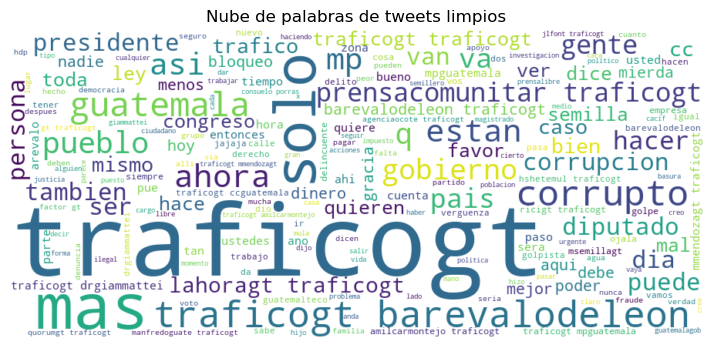

In [8]:
text_for_wc = ' '.join(df['tweet_text_clean'].tolist())
wc = WordCloud(width=900, height=400, background_color='white').generate(text_for_wc)
plt.figure(figsize=(10,4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de tweets limpios')
plt.show()

In [9]:
frecuencias = wc.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])

<class 'dict'>
[('traficogt', 1.0), ('mas', 0.2769640479360852), ('solo', 0.2210386151797603), ('traficogt barevalodeleon', 0.1804260985352863), ('corrupto', 0.1711051930758988), ('guatemala', 0.15046604527296936), ('ahora', 0.12916111850865514), ('estan', 0.1284953395472703), ('asi', 0.12250332889480692), ('mp', 0.12117177097203728)]


#### Preguntas



1. ¿Cuáles son las horas del día con mayor cantidad de reportes de tráfico?
2. ¿Cuáles son los días de la semana con mayor actividad en los reportes de tráfico?
3. ¿Qué cuentas de Twitter son las más mencionadas en los reportes de tráfico?

In [10]:
import pandas as pd


df['date'] = pd.to_datetime(df['date'], errors='coerce')

gt_tz = pytz.timezone('America/Guatemala')

if df['date'].dt.tz is None:
    df['date_local'] = df['date'].dt.tz_localize('UTC').dt.tz_convert(gt_tz)
else:
    df['date_local'] = df['date'].dt.tz_convert(gt_tz)

horas = (
    df.dropna(subset=['date_local'])
      .assign(hora=lambda x: x['date_local'].dt.hour)
      .groupby('hora', as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values('tweets', ascending=False)
      .reset_index(drop=True)
)

print(horas.head(10))



   hora  tweets
0    18     404
1    13     388
2    14     387
3    17     383
4    19     363
5    15     343
6     8     322
7    16     322
8    12     318
9     7     312


La hora más comun en la que los usuarios escriben sobre el trafico de Guatemala es justamente a las horas pico, que en este caso son a medio dia (1-2pm) y en la tarde (5-6pm)

In [11]:
dias_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

dias = (
    df.dropna(subset=['date'])
      .assign(dow=df['date'].dt.dayofweek,
              dia=lambda x: x['dow'].map(dias_map))
      .groupby(['dow','dia'], as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values(['tweets'], ascending=False)
)

dias_por_orden_semana = dias.sort_values('dow').drop(columns='dow')
dias_por_orden_semana



dia  tweets
0      Lunes     826
1     Martes    1081
2  Miércoles     882
3     Jueves     867
4    Viernes     719
5     Sábado     583
6    Domingo     638

Analizando los días en los que hay más tweets se puede ver que los dias entre semana son los que tienen más tweets, siendo el día martes el más alto. Cabe recalcar que fin de semana la cantidad de tweets baja un poco pero no tanto comparado a entre semana.

In [12]:
top_n = 10 
cuentas = (
    df.dropna(subset=['username'])
      .assign(username=lambda x: x['username'].str.lower().str.strip())
      .groupby('username', as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values('tweets', ascending=False)
)

cuentas_top = cuentas.head(top_n)
cuentas_top


username  tweets
1939        traficogt     781
225    batallonjalapa     133
1449   mildred_gaitan     103
1187         lahoragt      72
385   chofito63569841      47
160           angeln8      46
1657  prensacomunitar      40
911       hellboy17oc      39
1597     papaabumario      36
90    alejandro2024gt      33

Analizando los usuarios con más tweets traficogt es la cuenta que predomina y por mucho, ya que tiene 781 tweets y la segunda cuenta más popular es batallonjalapa con 133. Es comprensible que traficogt tenga tanta ventaja ya que se encargan de reportar cualquier tema relacionado con el trafico.

#### Análisis de la topología de la red

In [13]:

def to_list(x):
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return []
    if isinstance(x, list):
        return [str(z).strip() for z in x if str(z).strip()]
    if isinstance(x, str):
        s = x.strip()
        if (s.startswith('[') and s.endswith(']')) or (s.startswith('(') and s.endswith(')')):
            try:
                parsed = ast.literal_eval(s)
                return [str(z).strip() for z in parsed if str(z).strip()]
            except Exception:
                pass
        return [t.strip() for t in s.split(',') if t.strip()]
    return [str(x).strip()]

def safe_str(x):
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return None
    return str(x).strip() or None

for col in ["username", "mentionUsers", "reply_to", "retweeted_user"]:
    if col not in df.columns:
        df[col] = None

df["username"]       = df["username"].astype(str).str.strip()
df["mentionUsers"]   = df["mentionUsers"].apply(to_list)
df["reply_to"]       = df["reply_to"].apply(safe_str)
df["retweeted_user"] = df["retweeted_user"].apply(safe_str)


In [14]:
G = nx.DiGraph()

for u in df["username"].unique():
    if isinstance(u, str) and u:
        G.add_node(u)

edges = []
for _, row in df.iterrows():
    author = row["username"]
    for m in row["mentionUsers"]:
        if m and m != author:
            edges.append((author, m, {"type": "mention"}))
    if row["reply_to"] and row["reply_to"] != author:
        edges.append((author, row["reply_to"], {"type": "reply"}))
    if row["retweeted_user"] and row["retweeted_user"] != author:
        edges.append((author, row["retweeted_user"], {"type": "retweet"}))

G.add_edges_from(edges)
print(f"Nodos: {G.number_of_nodes()} | Aristas: {G.number_of_edges()}")


Nodos: 3132 | Aristas: 8731


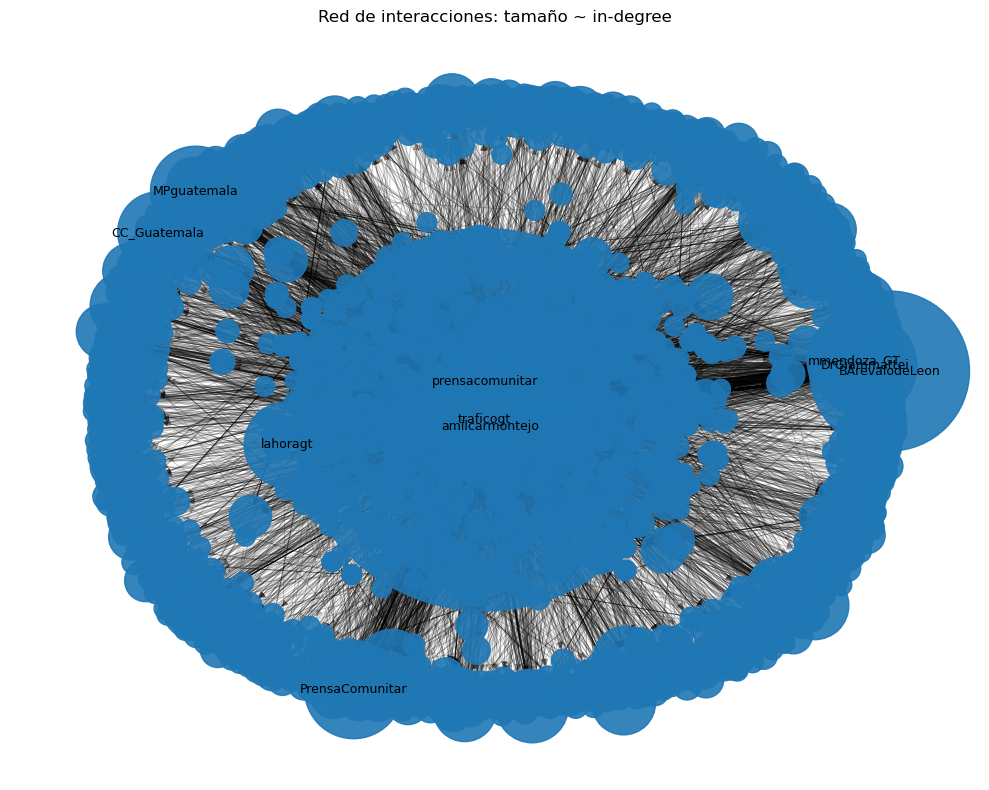

In [15]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

in_deg = dict(G.in_degree())
sizes = [200 + 40*in_deg.get(n, 0) for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="C0", alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.25, arrows=True, arrowsize=10, width=0.6)

top10_in = sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {n: n for n,_ in top10_in}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Red de interacciones: tamaño ~ in-degree")
plt.axis("off")
plt.tight_layout()
plt.show()


In [16]:
density = nx.density(G)

diameter = 0
if G.number_of_edges() > 0:
    G_und = G.to_undirected()
    largest_cc = max(nx.connected_components(G_und), key=len)
    H = G_und.subgraph(largest_cc).copy()
    diameter = nx.diameter(H) if H.number_of_nodes() > 1 else 0

clustering = nx.average_clustering(G.to_undirected()) if G.number_of_nodes() else 0.0

print(f"Densidad: {density:.4f}")
print(f"Diámetro (componente más grande): {diameter}")
print(f"Coef. de agrupamiento (promedio): {clustering:.4f}")


Densidad: 0.0009
Diámetro (componente más grande): 7
Coef. de agrupamiento (promedio): 0.1683


Densidad = 0.0009: La red es extremadamente dispersa. Esto es común en redes sociales grandes, donde la mayoría de los usuarios interactúan con pocos otros. Indica que hay muchas más posibles conexiones que las realmente existentes.

Diámetro = 7: La distancia más larga entre dos nodos dentro del componente más grande es moderada. Esto sugiere que, aunque hay pocos enlaces, sí existe un camino relativamente corto entre usuarios conectados.

Coeficiente de agrupamiento = 0.1683: Refleja una tendencia moderada a formar grupos o clústeres. Es decir, hay una probabilidad razonable de que los usuarios conectados a un mismo nodo también estén conectados entre sí, lo cual sugiere comunidades temáticas o grupos de conversación.

#### Identificación y análisis de comunidades

Uno de los algoritmos más utilizados para la detección de comunidades en redes sociales es el algoritmo de Louvain. Este método es ampliamente adoptado debido a que:

- Es rápido y eficiente incluso en redes grandes.

- Maximiza una métrica conocida como modularidad, que mide qué tan bien separadas están las comunidades dentro del grafo.

- Funciona de manera no supervisada, sin necesidad de parámetros manuales.

- Es fácilmente aplicable sobre grafos no dirigidos, como una aproximación válida para muchas redes sociales.

In [17]:
G_und = G.to_undirected()
communities = nx.algorithms.community.louvain_communities(G_und, seed=42)
print(f"Comunidades detectadas: {len(communities)}")

node2comm = {}
for cid, comm in enumerate(communities):
    for n in comm:
        node2comm[n] = cid
nx.set_node_attributes(G, node2comm, "community")


Comunidades detectadas: 55


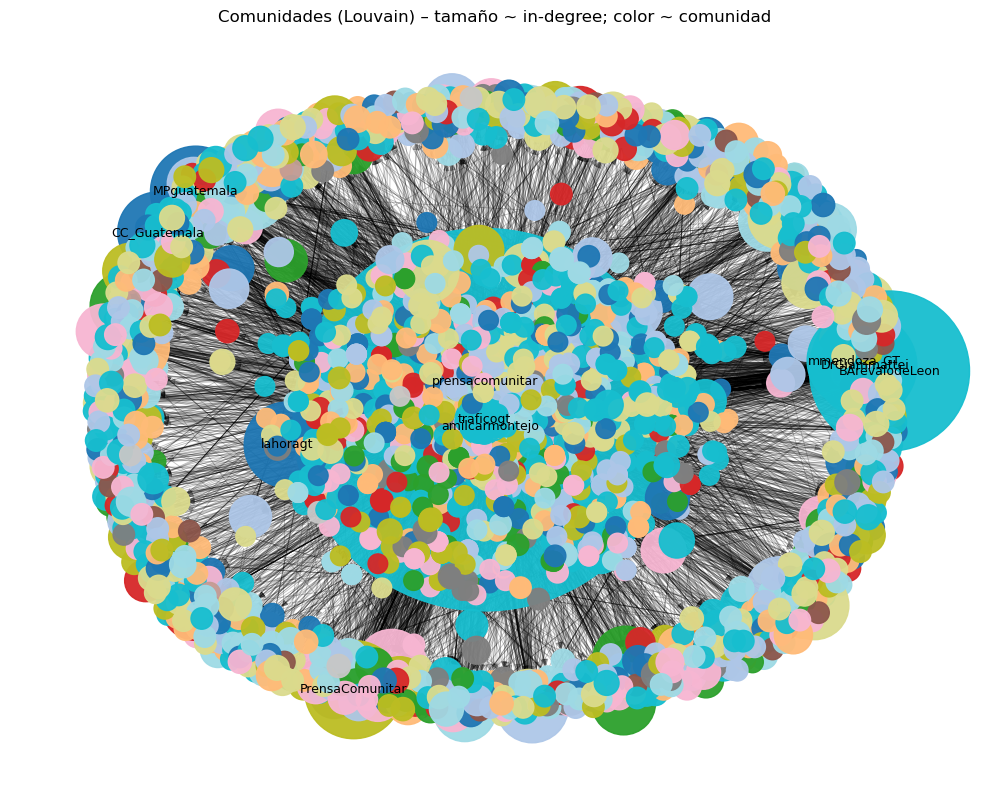

In [18]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

colors = [node2comm.get(n, -1) for n in G.nodes()]
sizes = [200 + 40*G.in_degree(n) for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, cmap="tab20", node_size=sizes, alpha=0.95)
nx.draw_networkx_edges(G, pos, alpha=0.25, arrows=True, arrowsize=10, width=0.6)

top10_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
labels = {n: n for n,_ in top10_in}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Comunidades (Louvain) – tamaño ~ in-degree; color ~ comunidad")
plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:

user2comm = {u: cid for cid, comm in enumerate(communities) for u in comm}


df["community_id"] = df["username"].map(user2comm)

sizes = [(cid, len(comm)) for cid, comm in enumerate(communities)]
top5_ids = [cid for cid, _ in sorted(sizes, key=lambda x: x[1], reverse=True)[:5]]
top5_ids


[50, 9, 5, 0, 36]

In [20]:

top_palabras_por_comm = {}

for cid in top5_ids:
    texto = " ".join(df.loc[df["community_id"] == cid, "tweet_text_clean"].dropna())
    top_palabras_por_comm[cid] = Counter(texto.split()).most_common(15)

# Vista rápida
for cid in top5_ids:
    print(f"\nComunidad {cid} – Top palabras:")
    print(", ".join([w for w,_ in top_palabras_por_comm[cid]]))



Comunidad 50 – Top palabras:
traficogt, barevalodeleon, mas, solo, corruptos, ser, guatemala, q, estan, mp, ahora, tambien, pais, puede, asi

Comunidad 9 – Top palabras:
traficogt, amilcarmontejo, muniguate, trafico, zona, guatemala, calle, pmtmuniguate, av, rquinonezl, villa, mas, avenida, pmtvillanueva, prensalibre

Comunidad 5 – Top palabras:
traficogt, barevalodeleon, q, mas, guatemala, ricigt, solo, jlfont, corruptos, drgiammattei, ahora, concriteriogt, ccguatemala, mp, asi

Comunidad 0 – Top palabras:
traficogt, lahoragt, mas, mpguatemala, ccguatemala, mp, detalles, q, guatemala, ahoralh, barevalodeleon, estan, ser, domingo, solo

Comunidad 36 – Top palabras:
traficogt, mas, barevalodeleon, msemillagt, pueblo, solo, karinherreravp, jmenkos, estan, thelmaaldana, ser, guatemala, corruptos, ahora, va


In [21]:
import pandas as pd

rows = []
for cid in top5_ids:
    nodes = communities[cid]
    subG = G.subgraph(nodes).copy()
    size = subG.number_of_nodes()
    edges = subG.number_of_edges()
    temas = ", ".join([w for w,_ in top_palabras_por_comm.get(cid, [])])
    rows.append({
        "community_id": cid,
        "n_usuarios": size,
        "interacciones": edges,
        "temas_principales": temas
    })

tabla_comunidades_top5 = pd.DataFrame(rows).sort_values("n_usuarios", ascending=False).reset_index(drop=True)
tabla_comunidades_top5


community_id  n_usuarios  interacciones  \
0            50         815           1162   
1             9         287            535   
2             5         235            418   
3             0         214            341   
4            36         192            327   

                                                                                                                                      temas_principales  
0                                       traficogt, barevalodeleon, mas, solo, corruptos, ser, guatemala, q, estan, mp, ahora, tambien, pais, puede, asi  
1  traficogt, amilcarmontejo, muniguate, trafico, zona, guatemala, calle, pmtmuniguate, av, rquinonezl, villa, mas, avenida, pmtvillanueva, prensalibre  
2               traficogt, barevalodeleon, q, mas, guatemala, ricigt, solo, jlfont, corruptos, drgiammattei, ahora, concriteriogt, ccguatemala, mp, asi  
3                    traficogt, lahoragt, mas, mpguatemala, ccguatemala, mp, detalles, q, guatemala, ahoralh, barevalodeleon, estan, ser, domingo, solo  
4          traficogt, mas, barevalodeleon, msemillagt, pueblo, solo, karinherreravp, jmenkos, estan, thelmaaldana, ser, guatemala, corruptos, ahora, va

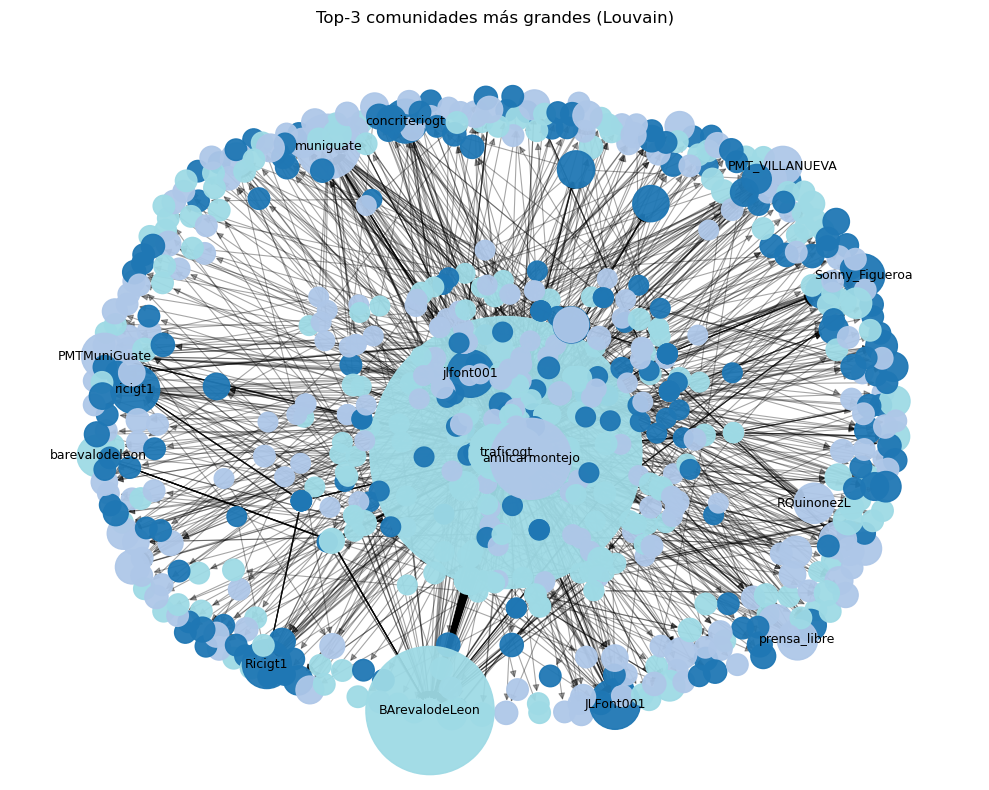

In [22]:
top3 = sorted(communities, key=len, reverse=True)[:3]
top3_nodes = set().union(*top3)
H = G.subgraph(top3_nodes).copy()
H_pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(10, 8))
H_colors = [node2comm.get(n, -1) for n in H.nodes()]
H_sizes = [200 + 40*H.in_degree(n) for n in H.nodes()]

nx.draw_networkx_nodes(H, H_pos, node_color=H_colors, cmap="tab20", node_size=H_sizes, alpha=0.95)
nx.draw_networkx_edges(H, H_pos, alpha=0.35, arrows=True, arrowsize=10, width=0.8)

top15_in = sorted(H.in_degree(), key=lambda x: x[1], reverse=True)[:15]
labels = {n: n for n,_ in top15_in}
nx.draw_networkx_labels(H, H_pos, labels=labels, font_size=9)

plt.title("Top‑3 comunidades más grandes (Louvain)")
plt.axis("off")
plt.tight_layout()
plt.show()


Analizando el top 3 de comunidades más grandes se puede notar un patrón entre ellas, principalmente con el usuario traficogt que aparece en las 3 comunidades. Analizando la comunidad más grande la cual tiene de usuarios principales a traficogt y a BArevalodeLeon, ya que son usuarios que tienen muchas interacciones con el tema del trafico. Para la segunda comunidad encontramos mención de muchos usuarios "oficiales" como PMTMuniGuate, PMT_VILLANUEVA, etc. Para la tercera comunidad se encuentras usuarios varios que tienen bastante interacción en temas de trafico como JLFont001 o Sonny_Figueroa. 

#### Análisis de influencers y nodos clave

In [23]:
deg_in   = dict(G.in_degree())
deg_out  = dict(G.out_degree())
deg_cent = nx.degree_centrality(G.to_undirected())
between  = nx.betweenness_centrality(G, k=min(500, G.number_of_nodes()), seed=42)
closeness = nx.closeness_centrality(G.to_undirected())

metrics7 = pd.DataFrame({
    "user": list(G.nodes()),
    "community_id": [node2comm.get(n, -1) for n in G.nodes()],
    "in_degree": [deg_in.get(n, 0) for n in G.nodes()],
    "out_degree": [deg_out.get(n, 0) for n in G.nodes()],
    "degree_centrality": [deg_cent.get(n, 0.0) for n in G.nodes()],
    "betweenness": [between.get(n, 0.0) for n in G.nodes()],
    "closeness": [closeness.get(n, 0.0) for n in G.nodes()],
})
metrics7.sort_values(["betweenness","in_degree"], ascending=False).head(15)


user  community_id  in_degree  out_degree  degree_centrality  \
0           traficogt            50       1891          63           0.623124   
2047   servoveritatis            54          1           5           0.001597   
1432  madridistaguate            51          1           4           0.001278   
424         jlfont001             5         35          13           0.015331   
1437   dianaresident4            54          1           5           0.001916   
210    mildred_gaitan            52         13         152           0.052379   
625       mmendoza_gt            51         52           5           0.018205   
2058      jdouglas182            54          2           4           0.001916   
648        guss_marro            51         23           2           0.007665   
78           quorumgt            54         39           3           0.013414   
63     batallonjalapa             5          2         153           0.049505   
1151      replikhante            36          1           4           0.001278   
583        ninomatute            44          7           1           0.002555   
1484  porqtendenciagt             5          6           1           0.002236   
36           lahoragt             0         90           2           0.029384   

      betweenness  closeness  
0        0.016877   0.717295  
2047     0.001518   0.416460  
1432     0.001138   0.416347  
424      0.001130   0.441119  
1437     0.000751   0.416516  
210      0.000639   0.439477  
625      0.000583   0.439540  
2058     0.000556   0.416629  
648      0.000390   0.434131  
78       0.000375   0.323562  
63       0.000228   0.438472  
1151     0.000195   0.416347  
583      0.000195   0.419591  
1484     0.000194   0.294927  
36       0.000100   0.450706

In [24]:
def top_k(dct, k=10):
    return sorted(dct.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top‑10 In‑Degree")
for u,v in top_k(deg_in, 10): print(f"{u:25s} {v}")

print("\nTop‑10 Betweenness")
for u,v in top_k(between, 10): print(f"{u:25s} {v:.5f}")

print("\nTop‑10 Closeness")
for u,v in top_k(closeness, 10): print(f"{u:25s} {v:.5f}")


Top‑10 In‑Degree
traficogt                 1891
BArevalodeLeon            327
DrGiammattei              132
PrensaComunitar           120
mmendoza_GT               109
MPguatemala               101
lahoragt                  90
amilcarmontejo            90
prensacomunitar           89
CC_Guatemala              79

Top‑10 Betweenness
traficogt                 0.01688
servoveritatis            0.00152
madridistaguate           0.00114
jlfont001                 0.00113
dianaresident4            0.00075
mildred_gaitan            0.00064
mmendoza_gt               0.00058
jdouglas182               0.00056
guss_marro                0.00039
quorumgt                  0.00038

Top‑10 Closeness
traficogt                 0.71730
BArevalodeLeon            0.47653
DrGiammattei              0.45566
mmendoza_GT               0.45317
MPguatemala               0.45150
lahoragt                  0.45071
JLFont001                 0.44573
EmisorasUnidas            0.44316
CongresoGuate             0.44290
ms

A partir de las métricas de centralidad calculadas, se identificaron los usuarios más influyentes según tres criterios clave:

1. Centralidad de grado

    Esta métrica identifica a los usuarios con más conexiones directas, es decir, quienes reciben o generan más menciones, retweets o respuestas.
    El usuario con el mayor grado total (in-degree + out-degree) es @traficogt, con 1,941 conexiones, lo que refleja su rol como nodo central en la conversación.
    Otros usuarios con alto grado incluyen @mildred_gaitan, @batallonjalapa, y @mmendoza_gt, lo cual indica que son altamente activos o frecuentemente mencionados.

2. Centralidad de intermediación (betweenness)

    Esta métrica resalta a los usuarios que actúan como puentes entre comunidades o subgrupos, permitiendo el flujo de información entre ellos.
    Nuevamente, @traficogt sobresale con una betweenness de 0.0169, lo que indica que conecta muchas rutas entre usuarios.
    Sin embargo, su valor es muy superior al resto, lo cual sugiere una posición dominante en la red. Otros usuarios tienen valores cercanos a cero, lo que indica que el flujo de información está altamente centralizado en esta cuenta.

3. Centralidad de cercanía (closeness)

    Esta métrica evalúa qué tan rápido un usuario puede llegar al resto de la red (en promedio).
    Los usuarios con mayor cercanía incluyen @traficogt (0.717), @jlfont001 (0.441), y @lahoragt (0.451). Esto indica que están estructuralmente bien posicionados para difundir información.
    Valores más bajos de cercanía indican posiciones más periféricas en la red.

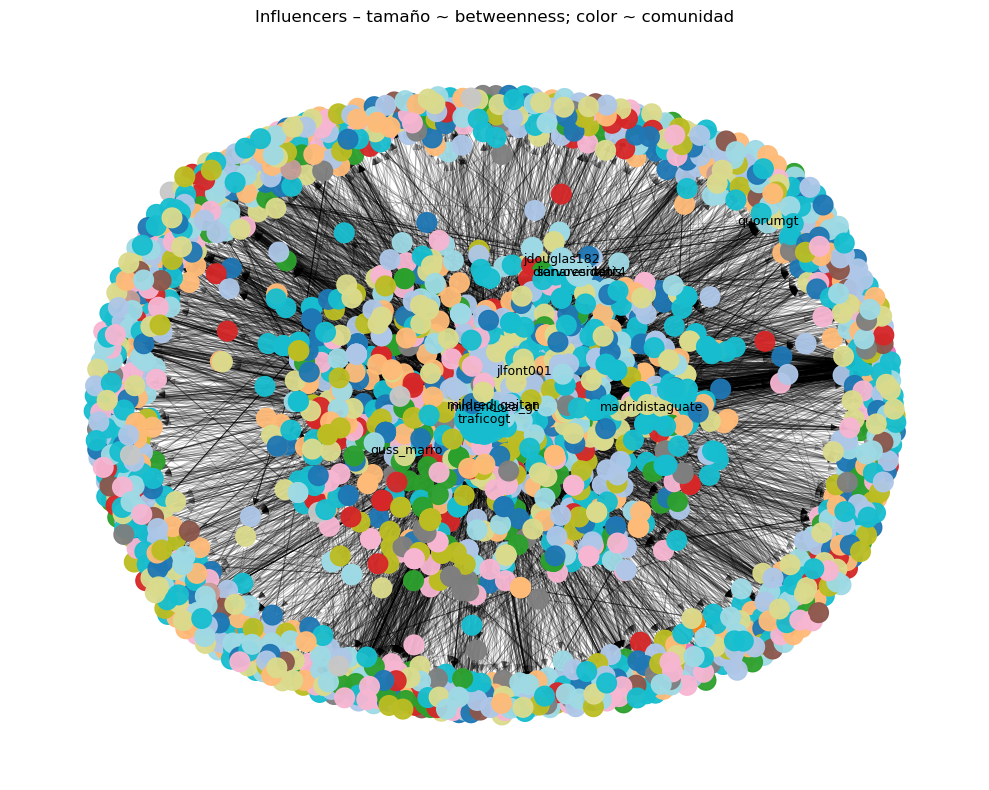

In [25]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

bvals = pd.Series(between)
sizes = 200 + 2000 * (bvals - bvals.min()) / (bvals.max() - bvals.min() + 1e-12)

nx.draw_networkx_nodes(
    G, pos,
    node_size=[sizes.get(n, 200) for n in G.nodes()],
    node_color=[node2comm.get(n, -1) for n in G.nodes()],
    cmap="tab20", alpha=0.95
)
nx.draw_networkx_edges(G, pos, alpha=0.25, arrows=True, arrowsize=10, width=0.6)

top10_b = bvals.sort_values(ascending=False).head(10).index.tolist()
labels = {n: n if n in top10_b else "" for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Influencers – tamaño ~ betweenness; color ~ comunidad")
plt.axis("off")
plt.tight_layout()
plt.show()


#### Detección y análisis de grupos aislados

In [26]:
G_und = G.to_undirected()
components = [G.subgraph(c).copy() for c in nx.connected_components(G_und)]

isolated_nodes = [list(c.nodes())[0] for c in components if c.number_of_nodes() == 1]
print(f"Subredes totales: {len(components)} | Nodos aislados: {len(isolated_nodes)}")

rows = []
for i, H in enumerate(components):
    n = H.number_of_nodes()
    e = H.number_of_edges()
    if n <= 10:  
        rows.append({
            "subred_id": i,
            "n_usuarios": n,
            "interacciones": e,
            "densidad": nx.density(H.to_undirected()) if n > 1 else 0.0
        })

subredes_peq_df = pd.DataFrame(rows).sort_values(["n_usuarios","interacciones"], ascending=[True, False]).reset_index(drop=True)
subredes_peq_df.head(32)

Subredes totales: 32 | Nodos aislados: 31


subred_id  n_usuarios  interacciones  densidad
0           1           1              0       0.0
1           2           1              0       0.0
2           3           1              0       0.0
3           4           1              0       0.0
4           5           1              0       0.0
5           6           1              0       0.0
6           7           1              0       0.0
7           8           1              0       0.0
8           9           1              0       0.0
9          10           1              0       0.0
10         11           1              0       0.0
11         12           1              0       0.0
12         13           1              0       0.0
13         14           1              0       0.0
14         15           1              0       0.0
15         16           1              0       0.0
16         17           1              0       0.0
17         18           1              0       0.0
18         19           1              0       0.0
19         20           1              0       0.0
20         21           1              0       0.0
21         22           1              0       0.0
22         23           1              0       0.0
23         24           1              0       0.0
24         25           1              0       0.0
25         26           1              0       0.0
26         27           1              0       0.0
27         28           1              0       0.0
28         29           1              0       0.0
29         30           1              0       0.0
30         31           1              0       0.0

Se identificaron 31 nodos aislados. Estos nodos no tienen ninguna interacción con la red principal, es decir, la red de tráfico. Como no tienen interacción, su densidad es de 0. Por lo mismo, no tienen una influencia en la red porque no llegan a aportar información. 

In [27]:
def top_words_for_nodes(nodes, k=10):
    textos = df.loc[df["username"].isin(nodes), "tweet_text_clean"].dropna()
    cnt = Counter(" ".join(textos).split())
    return [w for w,_ in cnt.most_common(k)]

tema_rows = []
for _, r in subredes_peq_df.iterrows():
    H = components[int(r["subred_id"])]
    temas = top_words_for_nodes(H.nodes(), k=10)
    tema_rows.append({"subred_id": int(r["subred_id"]), "temas_principales": ", ".join(temas)})

temas_df = pd.DataFrame(tema_rows)
subredes_peq_df = subredes_peq_df.merge(temas_df, on="subred_id", how="left")
subredes_peq_df.head(32)

subred_id  n_usuarios  interacciones  densidad  \
0           1           1              0       0.0   
1           2           1              0       0.0   
2           3           1              0       0.0   
3           4           1              0       0.0   
4           5           1              0       0.0   
5           6           1              0       0.0   
6           7           1              0       0.0   
7           8           1              0       0.0   
8           9           1              0       0.0   
9          10           1              0       0.0   
10         11           1              0       0.0   
11         12           1              0       0.0   
12         13           1              0       0.0   
13         14           1              0       0.0   
14         15           1              0       0.0   
15         16           1              0       0.0   
16         17           1              0       0.0   
17         18           1              0       0.0   
18         19           1              0       0.0   
19         20           1              0       0.0   
20         21           1              0       0.0   
21         22           1              0       0.0   
22         23           1              0       0.0   
23         24           1              0       0.0   
24         25           1              0       0.0   
25         26           1              0       0.0   
26         27           1              0       0.0   
27         28           1              0       0.0   
28         29           1              0       0.0   
29         30           1              0       0.0   
30         31           1              0       0.0   

                                                                                                        temas_principales  
0                                       camion, frenos, embiste, varios, vehiculos, bajando, san, jose, pinula, desconoce  
1                                                    compartimos, orden, dia, desarrollara, sesionordinaria, xlegislatura  
2                                                                          bancadavamos, poblacion, guatemalteca, informa  
3                              perdieron, espacio, voto, ejecutivo, junta, directiva, congreso, veces, direccion, bantrab  
4                                         meses, duro, nuevo, congreso, verlos, regresar, manas, marufias, siempre, estan  
5   corrupcion, tablerocorrupcion, presentamos, tablero, expedientes, iniciativa, evidenciar, denuncias, posibles, hechos  
6                                                                                                                   culpa  
7                                 ex, magistrada, blanca, stalling, increpada, afueras, torre, tribunales, dijeron, cosas  
8                                arzu, jr, importa, alimentacion, saludable, gente, extraccion, petrolera, perenco, puros  
9                                         calle, avenida, zona, hicieron, trabajo, dejaron, asi, carril, reversibles, san  
10                                      informe, departamento, tesoro, gobierno, ee, uu, revelo, cartel, sinaloa, joaquin  
11                             tantos, seguidores, humilde, red, social, gustaria, ayudaran, difundir, lamentable, suceso  
12                                                        gobierno, guatemala, reafirma, relaciones, diplomaticas, taiwan  
13                                      agentes, vida, hacen, respecto, seria, interesante, hacer, experimento, par, dias  
14                               sera, responsable, autorizar, salida, carros, centro, comercial, incorpora, via, fluidez  
15                               alguna, vez, habian, visto, ministro, gobernacion, interactuando, aca, tomando, acciones  
16                                  digan, presidente, congreso, trajimos, abajo, ustedes, mas, temprano, tarde, quedaran  
17                              electoral, 

Como se puede ver, en los nodos aislados los temas de los tweets no tienen que ver con el tráfico. Esto resalta el hecho de que no tengan relación con los temas de la red principal y que interacción sea 0. 

In [28]:
G_und = G.to_undirected()
components = [G.subgraph(c).copy() for c in nx.connected_components(G_und)]

isolated_nodes = [list(c.nodes())[0] for c in components if c.number_of_nodes() == 1]
print(f"Nodos aislados: {len(isolated_nodes)}")

deg_centrality_all = nx.degree_centrality(G.to_undirected())

try:
    between  
except NameError:
    between = nx.betweenness_centrality(G, k=min(500, G.number_of_nodes()), seed=42)

closeness_all = nx.closeness_centrality(G.to_undirected())

in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

rows = []
for n in isolated_nodes:
    rows.append({
        "user": n,
        "in_degree": in_deg.get(n, 0),
        "out_degree": out_deg.get(n, 0),
        "degree_total": in_deg.get(n, 0) + out_deg.get(n, 0),
        "degree_centrality": deg_centrality_all.get(n, 0.0),
        "betweenness": between.get(n, 0.0),
        "closeness": closeness_all.get(n, 0.0),
    })

isolates_cent_df = pd.DataFrame(rows).sort_values(["degree_total","user"], ascending=[False, True]).reset_index(drop=True)
isolates_cent_df

Nodos aislados: 31


user  in_degree  out_degree  degree_total  degree_centrality  \
0         adiariogt          0           0             0                0.0   
1   allanerodriguez          0           0             0                0.0   
2    arturomcfields          0           0             0                0.0   
3     ca360noticias          0           0             0                0.0   
4      carlomarcogt          0           0             0                0.0   
5     carmencrdelon          0           0             0                0.0   
6        cc_chiquin          0           0             0                0.0   
7        clousgario          0           0             0                0.0   
8      cncguatemala          0           0             0                0.0   
9     congresoguate          0           0             0                0.0   
10  crayola_purpura          0           0             0                0.0   
11    doctordelagua          0           0             0                0.0   
12         eomarroq          0           0             0                0.0   
13          fundesa          0           0             0                0.0   
14   guatealejandro          0           0             0                0.0   
15   guatevision_tv          0           0             0                0.0   
16   interiano1saul          0           0             0                0.0   
17    intoamountain          0           0             0                0.0   
18           jorwel          0           0             0                0.0   
19    leninistaluis          0           0             0                0.0   
20       mafersita8          0           0             0                0.0   
21   maxsantacruz68          0           0             0                0.0   
22         nyfls123          0           0             0                0.0   
23  quiquegarcia502          0           0             0                0.0   
24   renasuspendido          0           0             0                0.0   
25  santizoreloaded          0           0             0                0.0   
26    senmarcorubio          0           0             0                0.0   
27     spillariales          0           0             0                0.0   
28      vientomares          0           0             0                0.0   
29  viniciogutierr3          0           0             0                0.0   
30      vjavierhndz          0           0             0                0.0   

    betweenness  closeness  
0           0.0        0.0  
1           0.0        0.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0  
5           0.0        0.0  
6           0.0        0.0  
7           0.0        0.0  
8           0.0        0.0  
9           0.0        0.0  
10          0.0        0.0  
11          0.0        0.0  
12          0.0        0.0  
13          0.0        0.0  
14          0.0        0.0  
15          0.0        0.0  
16          0.0        0.0  
17          0.0        0.0  
18          0.0        0.0  
19          0.0        0.0  
20          0.0        0.0  
21          0.0        0.0  
22          0.0        0.0  
23          0.0        0.0  
24          0.0        0.0  
25          0.0        0.0  
26          0.0        0.0  
27          0.0        0.0  
28          0.0        0.0  
29          0.0        0.0  
30          0.0        0.0

Como los nodos aislados tienen interacción 0, la centralidad de grado, centralidad de intermediación y centralidad de cercanía tienen un valor de 0.

#### Análisis de contenido y sentimiento

In [29]:
nltk.download('vader_lexicon')
nltk.download('punkt')

sia = SentimentIntensityAnalyzer()

def clasificar_sentimiento(texto):
    if not texto or not isinstance(texto, str):
        return "neutral"
    scores = sia.polarity_scores(texto)
    compound = scores["compound"]
    if compound >= 0.05:
        return "positivo"
    elif compound <= -0.05:
        return "negativo"
    else:
        return "neutral"

df["sentiment_polarity"] = df["tweet_text_clean"].apply(clasificar_sentimiento)
df[["tweet_text_clean", "sentiment_polarity"]].head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dfsf2\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dfsf2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


tweet_text_clean  \
0                                                                                                                                                                                                          comprensible resolucion ruso sabe engrasar maquinaria   
1                                                                                                                                                                            corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi   
2                                                                                                                                                                                pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt   
3  amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza   
4                                     aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz   
5                                                                                                            amilcarmontejo pmtmuniguate noti guatemala nuestrodiario t noticias aztecaguate traficogt avenidas calles avenida calle luz semaforo agentes emetra   
6                                                                                                                                                                favor compartir vive zona bethania traficogt amilcarmontejo pncdeguatemala urgente desaparecido   
7                             traficogt ojoconmipisto aztecanoticiagt aztecanoticiagt muniguate conapgt denunciaempagua emisorasunidas epinvestiga luisvengt samuelpz josechic ciudadcayala marnguate karinapazgt vecinosz importante ponerle atencion vecinos z   
8                                                                                                                               pierocoen fjimenezmingob traficogt mingobguate pncdeguatemala diariodeca agnnoticias radiotgw guatemalagob pajas mota ahora vale   
9                                                                                          erwinfern pierocoen fjimenezmingob traficogt mingobguate pncdeguatemala diariodeca agnnoticias radiotgw guatemalagob ayyyy arde fumen mota mejor segui chimando bebes   

  sentiment_polarity  
0            neutral  
1            neutral  
2            neutral  
3            neutral  
4            neutral  
5            neutral  
6           positivo  
7            neutral  
8            neutral  
9            neutral

In [30]:
sent_global = df["sentiment_polarity"].value_counts(normalize=True).rename_axis("polaridad").reset_index(name="proporcion")
print("Distribución global de sentimiento:")
print(sent_global)

sent_por_comm = (
    df.groupby("community_id")["sentiment_polarity"]
      .value_counts(normalize=True)
      .rename("proporcion")
      .reset_index()
      .pivot(index="community_id", columns="sentiment_polarity", values="proporcion")
      .fillna(0)
      .reset_index()
)

resumen_top5_sent = sent_por_comm[sent_por_comm["community_id"].isin(top5_ids)].reset_index(drop=True)
resumen_top5_sent

Distribución global de sentimiento:
  polaridad  proporcion
0   neutral    0.921372
1  positivo    0.060222
2  negativo    0.018406


sentiment_polarity  community_id  negativo   neutral  positivo
0                              0  0.028205  0.928205  0.043590
1                              5  0.017822  0.899010  0.083168
2                              9  0.005025  0.927136  0.067839
3                             36  0.021472  0.911043  0.067485
4                             50  0.014269  0.933790  0.051941

In [31]:
import re
from collections import Counter

TEXT_COL = "text_clean" if "text_clean" in df.columns else "tweet_text_clean"

def simple_tokenize_es(text, min_len=3):
    toks = re.findall(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9#_]+", (text or "").lower())
    return [t for t in toks if len(t) >= min_len]

tokens_global = []
for t in df[TEXT_COL].dropna():
    tokens_global.extend(simple_tokenize_es(t))

conteo_global = Counter(tokens_global)
print("Top 20 palabras más frecuentes en toda la red:")
conteo_global.most_common(20)

Top 20 palabras más frecuentes en toda la red:


[('traficogt', 4256),
 ('mas', 444),
 ('barevalodeleon', 432),
 ('solo', 324),
 ('guatemala', 300),
 ('estan', 209),
 ('corruptos', 202),
 ('ahora', 200),
 ('asi', 189),
 ('pueblo', 186),
 ('ser', 185),
 ('drgiammattei', 175),
 ('presidente', 171),
 ('amilcarmontejo', 167),
 ('prensacomunitar', 162),
 ('gobierno', 145),
 ('pais', 141),
 ('mpguatemala', 139),
 ('gente', 135),
 ('mmendozagt', 131)]

La distribución global de los tweets de la base de datos tiene una polaridad neutral de un 92%, lo que indica que casi todos los usuarios discuten los temas con un tono neutral, en lugar de positivo o negativo. La polaridad positiva le sigue con un 6%, lo cual es bastante bajo comparado con el enfoque neutral. 

In [32]:
import re
from collections import Counter

def simple_tokenize_es(text, min_len=3):
    return re.findall(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9#_]{%d,}" % min_len, (text or "").lower())

trafico_df = df[df["username"].str.lower() == "traficogt"]

tokens_trafico = []
for t in trafico_df["tweet_text_clean"].dropna():
    tokens_trafico.extend(simple_tokenize_es(t))

top_trafico = Counter(tokens_trafico).most_common(20)

print("Temas más frecuentes en @traficogt:")
print(", ".join([w for w,_ in top_trafico]))

Temas más frecuentes en @traficogt:
solo, mas, corruptos, gracias, guatemala, estan, debe, tambien, golpe, ser, ahora, pueblo, tiempo, hacer, muletas, pacto, cacif, paso, magistrados, deben


@traficogt tiene interacción prácticamente en todas las comunidades. Por esto, los temas principales que se mencionan se alinean a los más comunes en las comunidades, como por ejemplo corruptos, tráfico, guatemala, tiempo. 

#### Interpretación y contexto


Durante el análisis de la red social se identificó que existen ciertos influencers que concentran la mayoría de interacciones relacionadas al tráfico. Estos usuarios, como es el caso claro de @traficogt, no solo tienen el mayor número de conexiones y menciones, sino que también actúan como puentes de información entre comunidades distintas. En contraste, las páginas oficiales (como cuentas gubernamentales o institucionales) tienen una participación mucho más reducida o dispersa, lo que refuerza el papel dominante de estas cuentas ciudadanas o especializadas en tráfico como las verdaderas fuentes de información en tiempo real.

Este comportamiento refleja una descentralización institucional en la comunicación del tráfico y una confianza más alta en canales ciudadanos, especialmente en momentos críticos como lluvias, accidentes o bloqueos. En un marco social más amplio, esto también evidencia cómo la opinión pública se forma alrededor de cuentas que tienen una fuerte presencia en Twitter/X y que funcionan casi como medios alternativos o comunitarios. Estas cuentas no solo informan, sino que también moldean la percepción colectiva del caos vial, al amplificar reportes locales, fotos, quejas y comentarios en tiempo real.

Conclusiones generales del análisis

- @traficogt domina completamente la conversación sobre tráfico en Guatemala, tanto en cantidad de conexiones directas como en su papel como puente entre comunidades. Su presencia es nacional y transversal a toda la red.

- Se detectaron comunidades bien definidas que se agrupan por temas o regiones, y que se conectan principalmente a través de nodos grandes como traficogt. Estas comunidades permiten observar cómo se organiza la información desde distintos puntos del país.

- El análisis de sentimiento reveló que la mayoría de los tweets son neutrales, lo cual tiene sentido considerando que los usuarios usualmente reportan eventos (accidentes, tráfico, cierres) sin emitir juicio emocional.

- Aparecieron nodos y subredes aisladas sin interacción con el tema principal (el tráfico). Es curioso ver estas conexiones, ya que no hay enlaces reales con la conversación dominante, lo que puede reflejar cuentas que publican de forma automática, fuera de contexto o sin generar respuesta.

- La red presenta características típicas de una red social: baja densidad, clustering moderado, y alta centralización en pocos nodos, lo que refuerza la idea de que la conversación está fuertemente dirigida por unos pocos actores clave.